# ThorDelayAnalysis
---

## Common delay I/O
---
\begin{equation}
    \displaystyle y(n) = \sum_{m = 0}^{M} a^{m} x(n - md)
\end{equation}

## Thor's delay
---
### Parameters
![DelayPanel](Fig\DelayPanel)

|Name|Unit|Min val|Max val|
|:--:|:--:|:--:|:--:|
|TIME|ms|0|1000|
|F.BACK|-|0|127|
|RATE|Hz|0.14|18.2|
|AMT|-|0|127|
|D.WET|-|0|127|

## Rec IR
---

### Create input inpulse train

0         1.0
48000     1.0
96000     1.0
144000    1.0
192000    1.0
240000    1.0
288000    1.0
336000    1.0
384000    1.0
432000    1.0
dtype: float64


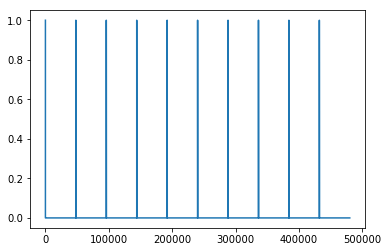

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#samplerate = 48 kHz, period = 1 sec, signal_length = 10 sec
fs = 48000
period = fs
length = period * 10 #10 sec

#Create IT and show
inpulse_train = np.arange(length) % period < 1
inpulse_train = inpulse_train.astype(np.float)

ser = pd.Series(inpulse_train)
ser = ser[inpulse_train > 0]
print(ser)

plt.plot(range(inpulse_train.size), inpulse_train)
plt.show()

0         0.999969
48000     0.999969
96000     0.999969
144000    0.999969
192000    0.999969
240000    0.999969
288000    0.999969
336000    0.999969
384000    0.999969
432000    0.999969
dtype: float64


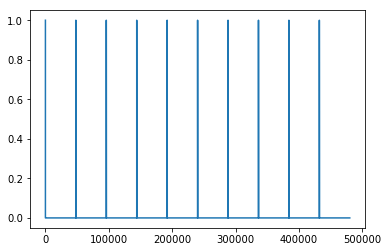

In [2]:
import soundfile as sf

#save as wavefile
sf.write("ImpulseTrain_fs48kHz_p1sec_len10sec.wav", inpulse_train, int(fs))

#load wav and show
inpulse_wav, _ = sf.read("ImpulseTrain_fs48kHz_p1sec_len10sec.wav")

ser = pd.Series(inpulse_wav)
ser = ser[inpulse_wav > 0]
print(ser)

plt.plot(range(inpulse_wav.size), inpulse_wav)
plt.show()

### IR rec conditions
InputSignal: Impulse Train (freq. 1 Hz, fs 48 kHz, bit 16, len 10 sec, Mono)  
OutSignal: Input(Mono) -> Thor Filter3 (L & R) -> Thor Delay -> Out (Stereo)

![BackPanel](Fig\BackPanel)
![Looting](Fig\Looting)

## Analysis of "TIME" parameter dependence
---
### Mesurement conditions
|Entry|TIME|F.BACK|RATE|AMT|D.WET|
|:--:|:--:|:--:|:--:|:--:|:--:|
|T_0|0|0|0.14|0|0|
|T_1|0|0|0.14|0|127|
|T_2|197|0|0.14|0|127|
|T_3|402|0|0.14|0|127|
|T_4|606|0|0.14|0|127|
|T_5|803|0|0.14|0|127|

![InpulseRec](Fig\InpulseRec)

In [3]:
def msec_to_sample_fs48kHz(t_msec):
    return t_msec / 1000.0 * 48000

T_msec = [0, 197, 402, 606, 803]
T_samp = [msec_to_sample_fs48kHz(x) for x in T_msec]

index_label = ["T_1", "T_2", "T_3", "T_4", "T_5"]
df = pd.DataFrame({"msec": T_msec, "sample": T_samp}, index = index_label)

df

,msec,sample
T_1,0,0.0
T_2,197,9456.0
T_3,402,19296.0
T_4,606,29088.0
T_5,803,38544.0


### Analysis of IRs

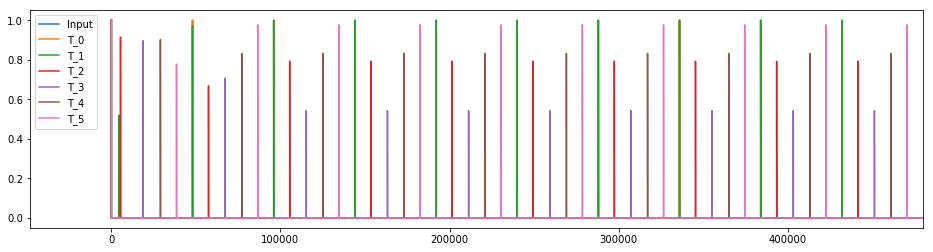

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
%matplotlib inline

def extract_left_channel(stereo_wav, _):
    return stereo_wav[:, 0] 

input_inpulse, fs = sf.read("ImpulseTrain_fs48kHz_p1sec_len10sec.wav")
T_data = []
T_data.append(extract_left_channel(*sf.read("IR\T_0.wav")))
T_data.append(extract_left_channel(*sf.read("IR\T_1.wav")))
T_data.append(extract_left_channel(*sf.read("IR\T_2.wav")))
T_data.append(extract_left_channel(*sf.read("IR\T_3.wav")))
T_data.append(extract_left_channel(*sf.read("IR\T_4.wav")))
T_data.append(extract_left_channel(*sf.read("IR\T_5.wav")))

plt.figure(figsize = (16, 4))
plt.plot(range(input_inpulse.size), input_inpulse, label = "Input")
for num, data in enumerate(T_data):
    label_name = "T_" + str(num)
    plt.plot(range(data.size), data, label = label_name)
plt.xlim(-fs, fs * 10)
plt.legend()
plt.show()

0-1周期目は安定していない？  
3周期目を取り出して、各IRの遅延サンプル時間を特定

0         0.999969
4593      0.519989
48005     0.971466
48006     0.027710
96002     0.999969
144002    0.999969
192002    0.999969
240002    0.999969
288002    0.999969
336002    0.999969
384002    0.999969
432002    0.999969
dtype: float64


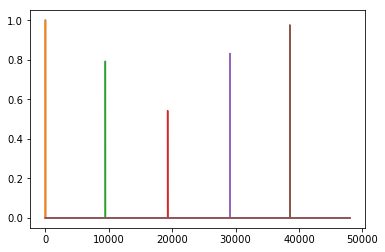

,0,2,9448,9449,19275,19276,29102,29103,38551,38552
0,0.999969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.999969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.207031,0.792938,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.457031,0.542938,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.832001,0.167969,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.976532,0.023438


In [14]:
def extract_cycle(IR_list, cycle):
    new_data_set = []
    st = fs * cycle
    en = st + fs
    
    for data in IR_list:
        new_data_set.append(data[st : en])
        
    return new_data_set

def extract_position_intensity(IR, threshold):
    s = pd.Series(IR)
    return s[IR > threshold] 

print(extract_position_intensity(T_data[1], 0))

#第3周期のIRを抽出
T_extract = extract_cycle(T_data, 3)

for num, data in enumerate(T_extract):
    label_name = "T_" + str(num)
    plt.plot(range(data.size), data)

plt.show()

#0を除外して、整理
T_ser = []
for data in T_extract:
    T_ser.append(extract_position_intensity(data, 0))

df = pd.DataFrame(T_ser)
df

右チャンネル出力についても同様に解析

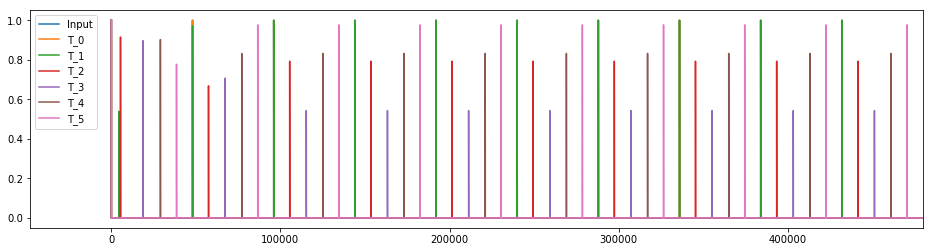

0         0.999969
4593      0.540009
48005     0.971466
48006     0.027740
96002     0.999969
144002    0.999969
192002    0.999969
240002    0.999969
288002    0.999969
336002    0.999969
384002    0.999969
432002    0.999969
dtype: float64


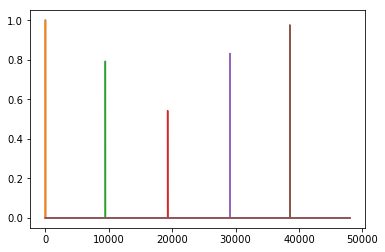

,0,2,9448,9449,19275,19276,29102,29103,38551,38552
0,0.999969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.999969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.207031,0.792938,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.457031,0.542938,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.832001,0.167969,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.976532,0.023438


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
%matplotlib inline

def extract_right_channel(stereo_wav, _):
    return stereo_wav[:, 1] 

input_inpulse, fs = sf.read("ImpulseTrain_fs48kHz_p1sec_len10sec.wav")
T_data = []
T_data.append(extract_right_channel(*sf.read("IR\T_0.wav")))
T_data.append(extract_right_channel(*sf.read("IR\T_1.wav")))
T_data.append(extract_right_channel(*sf.read("IR\T_2.wav")))
T_data.append(extract_right_channel(*sf.read("IR\T_3.wav")))
T_data.append(extract_right_channel(*sf.read("IR\T_4.wav")))
T_data.append(extract_right_channel(*sf.read("IR\T_5.wav")))

plt.figure(figsize = (16, 4))
plt.plot(range(input_inpulse.size), input_inpulse, label = "Input")
for num, data in enumerate(T_data):
    label_name = "T_" + str(num)
    plt.plot(range(data.size), data, label = label_name)
plt.xlim(-fs, fs * 10)
plt.legend()
plt.show()

def extract_cycle(IR_list, cycle):
    new_data_set = []
    st = fs * cycle
    en = st + fs
    
    for data in IR_list:
        new_data_set.append(data[st : en])
        
    return new_data_set

def extract_position_intensity(IR, threshold):
    s = pd.Series(IR)
    return s[IR > threshold] 

print(extract_position_intensity(T_data[1], 0))

#第3周期のIRを抽出
T_extract = extract_cycle(T_data, 3)

for num, data in enumerate(T_extract):
    label_name = "T_" + str(num)
    plt.plot(range(data.size), data)

plt.show()

#0を除外して、整理
T_ser = []
for data in T_extract:
    T_ser.append(extract_position_intensity(data, 0))

df = pd.DataFrame(T_ser)
df

### Measured vs calced delay value
左右チャンネルで同様の結果、この時点でステレオ性なし  
2周期目以降のIRの遅延サンプル時間は安定  
遅延時間については、計算値とややぶれあり


|Entry|mesured|calced|
|:--:|:--:|:--:|
|T_1|2.0|0.0|
|T_2|9448.5|9456.0|
|T_3|19275.5|19296.0|
|T_4|29102.5|29088.0|
|T_5|38551.5|38544.0|

## Analysis of "F.Back" parameter dependence
---

### Mesurement conditions
|Entry|TIME|F.BACK|RATE|AMT|D.WET|
|:--:|:--:|:--:|:--:|:--:|:--:|
|F_0|197|0|0.14|0|127|
|F_1|197|20|0.14|0|127|
|F_2|197|40|0.14|0|127|
|F_3|197|60|0.14|0|127|
|F_4|197|80|0.14|0|127|
|F_5|197|100|0.14|0|127|

### Analysis of IRs

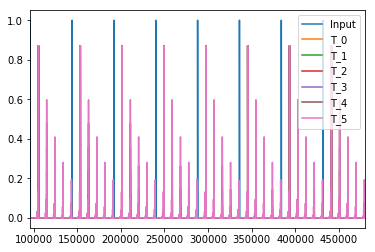

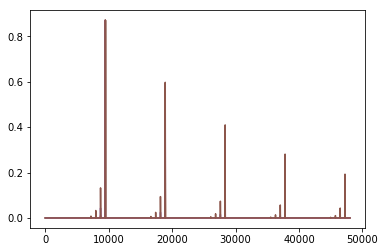

,8693,8694,9448,9449,18142,18143,18897,18898,27591,27592,28346,28347,37040,37795,37796,47244,47245
0,NaN,NaN,0.128906,0.871063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.128906,0.871063,NaN,NaN,NaN,0.119507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.128906,0.871063,NaN,NaN,0.070740,0.238983,NaN,NaN,NaN,0.065582,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.128906,0.871063,NaN,NaN,0.106110,0.358490,NaN,NaN,0.065491,0.147522,NaN,NaN,0.060699,NaN,NaN
4,NaN,NaN,0.128906,0.871063,NaN,NaN,0.141449,0.477966,NaN,NaN,0.116425,0.262268,NaN,0.085175,0.143921,0.058441,0.078979
5,0.117401,0.132233,0.128906,0.871063,0.093964,0.090698,0.176819,0.597473,0.073639,0.062225,0.181915,0.409790,0.056824,0.166382,0.281097,0.142639,0.192810


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
%matplotlib inline

def extract_left_channel(stereo_wav, _):
    return stereo_wav[:, 0] 

input_inpulse, fs = sf.read("ImpulseTrain_fs48kHz_p1sec_len10sec.wav")
T_data = []
T_data.append(extract_left_channel(*sf.read("IR\F_0.wav")))
T_data.append(extract_left_channel(*sf.read("IR\F_1.wav")))
T_data.append(extract_left_channel(*sf.read("IR\F_2.wav")))
T_data.append(extract_left_channel(*sf.read("IR\F_3.wav")))
T_data.append(extract_left_channel(*sf.read("IR\F_4.wav")))
T_data.append(extract_left_channel(*sf.read("IR\F_5.wav")))

#plt.figure(figsize = (16, 4))
plt.plot(range(input_inpulse.size), input_inpulse, label = "Input")
for num, data in enumerate(T_data):
    label_name = "T_" + str(num)
    plt.plot(range(data.size), data, label = label_name)
plt.xlim(fs * 2, fs * 10)
plt.legend()
plt.show()

def extract_cycle(IR_list, cycle):
    new_data_set = []
    st = fs * cycle
    en = st + fs
    
    for data in IR_list:
        new_data_set.append(data[st : en])
        
    return new_data_set

def extract_position_intensity(IR, threshold):
    s = pd.Series(IR)
    return s[IR > threshold] 

#第3周期のIRを抽出
T_extract = extract_cycle(T_data, 3)

for num, data in enumerate(T_extract):
    label_name = "T_" + str(num)
    plt.plot(range(data.size), data)

plt.show()

#0を除外して、整理
T_ser = []
for data in T_extract:
    T_ser.append(extract_position_intensity(data, 0.05))

df = pd.DataFrame(T_ser)
df

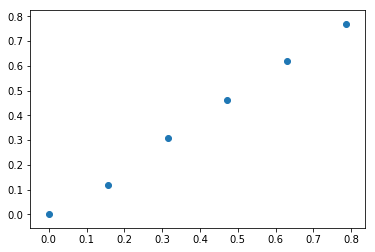

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array([0, 20, 40, 60, 80, 100]) / 127.0
y = np.array([0, 0.12, 0.31, 0.46, 0.62, 0.77])

plt.scatter(x, y)